In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# INSTALL & IMPORT LIBRARY

In [ ]:
!pip install underthesea
!pip install transformers
!pip install vncorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.6/599.6 kB 54.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 97.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 52.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vn

In [ ]:
from bs4 import BeautifulSoup
import numpy as np
import re
# from underthesea import word_tokenize
from keras.utils import to_categorical
from transformers import AutoTokenizer
from tensorflow.data import Dataset
import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
import pandas as pd

In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.2.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.2.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/


--2023-06-17 12:22:01--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.2.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412703 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.2.jar’

VnCoreNLP-1.2.jar   100%[===================>]  26.14M   156MB/s    in 0.2s    

2023-06-17 12:22:03 (156 MB/s) - ‘VnCoreNLP-1.2.jar’ saved [27412703/27412703]

--2023-06-17 12:22:03--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 

In [ ]:
from vncorenlp import VnCoreNLP


# PREPROCESSING

## LOAD DATA

In [ ]:
class TextNormalize:
    def __init__(self):
        self.vowels_to_ids = {}
        self.vowels_table = [
            ['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a' ],
            ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
            ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
            ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e' ],
            ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
            ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i' ],
            ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o' ],
            ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'o'],
            ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
            ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u' ],
            ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
            ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y' ]
        ]
        pass

    def createVowelsTable(self):
        """Create Vowels Table"""
        for i in range(len(self.vowels_table)):
            for j in range(len(self.vowels_table[i]) - 1):
                self.vowels_to_ids[self.vowels_table[i][j]] = (i, j)

    def IsValidVietnameseWord(self,word):
        """Nguyên âm chỉ có thể đứng chung với nguyên âm. Một từ không thể có 2 nguyên âm cách nhau bởi 1 phụ âm"""
        chars = list(word)
        #nguyen am
        vowel_index = -1
        for i in range(len(chars)):
            idx_vowel_table = self.vowels_to_ids.get(chars[i],(-1,-1))[0]
            if idx_vowel_table != -1:
                if vowel_index == -1:
                    vowel_index = i
                else:
                    if i - vowel_index != 1:
                        return False
                    vowel_index = i
        return True

    def WordStandardized(self,word):
        """Standardize Word"""
        if not self.IsValidVietnameseWord(word):
            return word

        chars = list(word)
        vowel_indexes = []

        # tìm vị trí nguyên âm
        qu_or_gi = False
        thanh_dieu = 0
        for i in range(len(chars)):
            vowel_table_row, vowel_table_col = self.vowels_to_ids.get(chars[i],(-1,-1))
            if vowel_table_row == -1 :
                continue
            # qu
            if vowel_table_row == 9:
                if i != 0 and chars[i-1] == 'q':
                    chars[i] = 'u'
                    qu_or_gi = True
            # gi
            elif vowel_table_row == 5:
                if i != 0 and chars[i-1] == 'g':
                    chars[i] = 'i'
                    qu_or_gi = True

            # có chứa thanh điệu
            if vowel_table_col != 0:
                thanh_dieu = vowel_table_col
                chars[i] = self.vowels_table[vowel_table_row][0]

            vowel_indexes.append(i)
        # 1 nguyên âm
        if len(vowel_indexes) == 1:
            c = chars[vowel_indexes[0]]
            chars[vowel_indexes[0]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
            return ''.join(chars)

        for idx_vowel in vowel_indexes:
            vowel_table_row, vowel_table_col = self.vowels_to_ids.get(chars[idx_vowel],(-1,-1))
            #ê, ơ, ô
            if vowel_table_row == 4 or vowel_table_row == 7 or vowel_table_row == 8:
                c = chars[idx_vowel]
                chars[idx_vowel] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                return ''.join(chars)

            # kiểm tra qu và gi, 2-3 nguyên âm thì nguyên âm thứ 2 chứa dấu
            if qu_or_gi:
                if len(vowel_indexes) == 2 or len(vowel_indexes) == 3:
                    c = chars[vowel_indexes[1]]
                    chars[vowel_indexes[1]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                return ''.join(chars)

            # 2 nguyên âm
            if len(vowel_indexes) == 2:
                # âm cuối là nguyên âm
                if vowel_indexes[-1] == len(chars) - 1:
                    c = chars[vowel_indexes[0]]
                    chars[vowel_indexes[0]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                else:
                    c = chars[vowel_indexes[-1]]
                    chars[vowel_indexes[-1]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                return ''.join(chars)

            elif len(vowel_indexes) == 3:
                # âm cuối là nguyên âm
                if vowel_indexes[-1] == len(chars) - 1:
                    c = chars[vowel_indexes[1]]
                    chars[vowel_indexes[1]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                else:
                    c = chars[vowel_indexes[-1]]
                    chars[vowel_indexes[-1]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                return ''.join(chars)

        return ''.join(chars)

    def normalize(self,text):

        #Chuyen sang viet thuong
        text = text.lower()

        # Rút gọn từ kéo dài
        text = re.sub(r'(\w)\1+',r'\1',text)

        # xóa các emoji dư thừa
        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'',text) # no emoji

        text = text.split()
        # chuẩn hóa thanh điệu
        for i in range(len(text)):
            text[i] = self.WordStandardized(text[i])

        text = ' '.join(text)

        # xóa space d
        text = re.sub(r"( )\1+",r'\1',text)
        text = re.sub(r"[:)^@!`~%;?(\+\-\'\"]+",r'',text)

        # remove hastag
        text = re.sub("(@[A-Za-z0-9]+)|(#[0-9A-Za-z]+)"," ", text)
        return text

In [ ]:
def convert_unicode(text):
  char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
  charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
  char1252 = char1252.split('|')
  charutf8 = charutf8.split('|')

  dic = {}
  for i in range(len(char1252)): dic[char1252[i]] = charutf8[i]
  return re.sub(
      r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
      lambda x: dic[x.group()], text
)


In [ ]:
class LoadData():
    def __init__(self, file_path):
        self.file_path = file_path

        self.data = pd.read_json(file_path)
        self.data = self.data.dropna()
        self.X = []
        self.y = []
    def transform(self,x,label):
        y = []
        first_index = label[:,0].astype(int)
        second_index = label[:,1].astype(int)

        # print(first_index)
        # print(second_index)
        # print("X:",x)
        s = 0
        a = ""
        # chay tu s -> first, cap nhat s
        for i in range(len(label)):

            front = x[s:first_index[i]]
            # print(first_index[i],second_index[i])
            middle = x[first_index[i]:second_index[i]]
            # print(x)
            # print(middle)
            s = second_index[i]

            a += front + " " + middle + " "
            y.extend(["O" for i in range(len(front.split()))])
            y.extend(["B-name" if i == 0 else "I-name" for i in range(len(middle.split()))])

        if s != len(x):
            a+= x[s:]
            y.extend(["O" for i in range(len(x[s:].split()))])

        # print(a)
        # for k, v in zip(a.split(),y):
        #     print(k,"=>",v)
        return a,np.array(y)

    def ExtractAspectTermPosition(self,aspectTerms):
        label = []
        # print(aspectTerms)
        for ls in aspectTerms:
            # label.append([int(tag['from']),int(tag['to']),tag['polarity']])
            label.append([int(ls['start']),int(ls['end'])])
        return np.array(sorted(label,key = lambda x: x[0]))

    def load(self,):
        _len = len(self.data)
        for i in range(_len):

            aspect_terms = self.data.iloc[i,2] #label

            x = self.data.iloc[i,0].strip() #text
            y = self.ExtractAspectTermPosition(aspect_terms)
            if len(y) == 0:
                continue
            x,y = self.transform(x,y)
            self.X.append(convert_unicode(x))
            self.y.append(y)

        return self.X,self.y

In [ ]:
data = LoadData("/content/drive/MyDrive/Đồ án KHDL/data.json")
X_raw,y_raw = data.load()

In [ ]:
X_raw[:5],y_raw[:5]

(['_ Ảnh chụp từ hôm qua, đi chơi với gia đình và 1 nhà họ hàng đang sống tại Sài Gòn. _ Hôm qua đi ăn trưa muộn, ai cũng đói hết nên lúc có đồ ăn là nhào vô ăn liền, bởi vậy mới quên chụp các phần gọi thêm với  nước mắm , chỉ chụp món chính thôi! _ Đói quá nên không biết đánh giá đồ ăn kiểu gì luôn 😅😅😅_ Chọn cái này vì thấy nó lạ với tui.',
  '_ Hương vị  thơm ngon, ăn cay cay rất thích, nêm nếm vừa miệng. Ngoài ra  menu  quán cũng nhiều món khác nhau tha hồ cho bạn lựa chọn luôn._Quán rộng rãi,  view  khá đẹp và cũng thoáng lắm. Khách của quán đông nên nhiều khi  nhân viên phục vụ  không được nhanh cho lắm._ Thịt heo rừng  giá theo kì nên nhớ hỏi trước nhưng trung bình là 150k 1 phần. Hai bạn đi chung chi khoảng 400k hơn là ổn nhé.',
  '- 1  bàn tiệc  hoành tráng 3 đứa ăn no muốn tắt thở mà  giá  chỉ 228k (ăn trung đợt giảm 10%), mình thích nhất  pad thái  vs  gà nướng  - đúng kiểu Thái luôn, quán nhỏ, trong hẻm, cơ mà  anh phục vụ  rất dễ thương,  chế biến  hợp vệ sinh,  bếp  lộ thi

In [ ]:
for k,v in zip(X_raw[960].split(),y_raw[960]):
  print(k,"=>",v)

Gà => B-name
nướng => I-name
chưa => O
giòn => O
da, => O
nhờ => O
có => O
sốt => B-name
chua => I-name
ngọt => I-name
, => O
thơm => O
vị => B-name
chanh => I-name
dây => I-name
nhè => O
nhẹ => O
nên => O
ăn => O
đỡ => O
ngán. => O
Có => O
kim => B-name
chi => I-name
giòn, => O
cay => O
ngon. => O
Xôi => B-name
nhìn => O
có => O
vẻ => O
hơi => O
khô, => O
nhưng => O
dẻo => O
ăn => O
cũng => O
ổn. => O
Thấy => O
đang => O
có => O
khuyến => O
mãi => O
ăn => O
1 => O
con => B-name
gà => I-name
169k => O
(1 => O
con => O
2 => O
vị) => O
được => O
tặng => O
1 => O
lẩu => B-name
lá => I-name
chúc => I-name
chua => O
trị => O
giá => O
69k. => O
Mà => O
quá => O
trể => O
T.T => O
ăn => O
xong => O
mới => O
thấy => O
:(( => O


# ASPECT TERM EXTRACTION

In [ ]:
PRETRAINED_MODEL = "vinai/phobert-base" #bert?
SEP = "</s>"
MAX_LEN = 256
BATCH_SIZE = 4

## ALIGN LABEL

Có 3 cách tokenize bảo toàn vị trí label:
* Chỉ gán lấy vị trí đầu : Washington => Wa ##shing ##ton (B-name,0,0)
* Gán hết vị trí: Washington => Wa ##shing ##ton (B-name,B-name,B-name)
* Gán vị trí đầu và các vị trí theo sau là `X`: Washington => Wa ##shing ##ton (B-name,X,X)

In [ ]:
class AlignLabel():
  def __init__(self):
    pass
  def Convert2LabelPosition(self,label):
    """
      Return label position
      ['O','O','B-name','I-name','O','B-name'] => [[2,3],[5,5]]
    """
    labels_position = []
    lst_first_pos = np.argwhere(label == "B-name").reshape(1,-1)[0]
    for i in range(len(lst_first_pos)):
      # if i reach last pos: label range should be (i,len(label))
      last_pos = lst_first_pos[i]
      if i == len(lst_first_pos) - 1:
        for j in range(lst_first_pos[i],len(label)):
          if label[j] == "I-name":
            last_pos = j
      else:
        for j in range(lst_first_pos[i],lst_first_pos[i+1]):
          if label[j] == "I-name":
            last_pos = j
      labels_position.append([lst_first_pos[i],last_pos])
    return np.array(labels_position)

  def segment_and_alignLabel(self,x,y,tokenizer, SEP):
    """
    Sengment one sentence and preserve label position
    "Địa điểm dễ tìm, lễ tân nhiệt tình" => "Địa_điểm dễ tìm, lễ_tân nhiệt tình"
    ["B-name", "I-name", "O", "O", "O", "B-name", "I-name", "O","O"] => ["B-name", "O", "O", "O", "B-name", "O","O"]
    """
    y_new = []
    label = self.Convert2LabelPosition(y)
    first_index = label[:,0].astype(int)
    second_index = label[:,1].astype(int)
    preprocess = TextNormalize()

    # single sequence: <s> X </s>
    # pair of sequences: <s> A </s> </s> B </s> </s> C </s>

    def segment_and_addSEP(seg,ismid):
        seg = tokenizer.tokenize(seg)
        seg = [" ".join(s) for s in seg]
        seg = " ".join(seg)

        # if ismid:
        #   seg = " ".join(seg)
        # else:
        #   seg = (" " + SEP + " " + SEP + " ").join(seg)
        return seg

    # print("X:",x)
    s = 0
    a = ""
    # chay tu s -> first, cap nhat s
    x = x.split()
    # print(x)
    for i in range(len(label)):
        front = " ".join(x[s:first_index[i]])
        if first_index[i] == second_index[i]:
          middle = x[first_index[i]]
          s = second_index[i] + 1
        else:
          middle = " ".join(x[first_index[i]:second_index[i]+1])
          s = second_index[i]+1

        # Preprocessing

        front = preprocess.normalize(front)
        middle = preprocess.normalize(middle)

        # add SEP token
        front = segment_and_addSEP(front,False)
        middle = segment_and_addSEP(middle,True )

        a += front + " " + middle + " "
        y_new.extend(["O" for i in range(len(front.split()))])

        if first_index[i] == second_index[i]:
          y_new.extend(["B-name"])
        else:
          y_new.extend(["B-name" if i == 0 else "I-name" for i in range(len(middle.split(" ")))])

    if s != len(x):
        enc = " ".join(x[s:])
        enc = preprocess.normalize(enc)
        enc = segment_and_addSEP(enc,False)
        a+= enc
        y_new.extend(["O" for i in range(len(enc.split()))])

    # print("a",a)
    # for k, v in zip(a.split(),y):
    #     print(k,"=>",v)
    a = " ".join(a.split())
    return [a,np.array(y_new)]

  def tokenize_and_alignlabel(self,x,y,tag2idx,tokenizer):
    x = x.strip().split(" ")
    # print(x)
    y_position = self.Convert2LabelPosition(y)
    # print(y_position)
    first_index = y_position[:,0]
    second_index = y_position[:,1]

    y_new = np.zeros(MAX_LEN)
    x_tokenize = []
    s = 0
    pre_len = 0
    y_position = 1
    for i in range(len(first_index)):
      front_len = len(tokenizer(" ".join(x[s:first_index[i]]),add_special_tokens = False)['input_ids'])
      y_new[y_position:y_position + front_len] = tag2idx["O"]
      y_position += front_len

      if first_index[i] == second_index[i]:
        words = tokenizer(x[first_index[i]],add_special_tokens = False)['input_ids']
        s = second_index[i] + 1
        # print(x[first_index[i]])

      else:
        # print(x[first_index[i]:second_index[i]+1],)
        words = tokenizer(" ".join(x[first_index[i]:second_index[i]+1]),add_special_tokens = False)['input_ids']
        s = second_index[i] + 1
      y_new[y_position] = tag2idx['B-name']
      # print(words)
      if len(words) >= 2:
        y_new[y_position+1:y_position+1+len(words)-1] = tag2idx['I-name'] # skip B-name position, subtract -1 because len(words) contain B-name

      y_position += len(words)

    tokenize_last_sents = tokenizer(" ".join(x[s:]),add_special_tokens = False)['input_ids']
    y_new[y_position:y_position + len(tokenize_last_sents) + 1] = tag2idx["O"]

    end_sep_position = y_position  + len(tokenizer(" ".join(x[s:])))

    y_new[0] = tag2idx['O']
    y_new[end_sep_position ] = tag2idx['O']

    return y_new

  def transform(self,x_raw,y_raw,rdrsegmenter,SEP):
    """
      Segment sentences X, if len(Sentences) > 120 => sentences / = 120
    """

    X = []
    Y = []
    for i in range(len(x_raw)):
      x, y = self.segment_and_alignLabel(x_raw[i],y_raw[i],rdrsegmenter,SEP)
      if len(x.split()) > 200:
        continue
      X.append(x)
      Y.append(y)
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X,Y

In [ ]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.2.jar", annotators="wseg", max_heap_size='-Xmx500m')


In [ ]:
# q = 11
# print(X_raw[q])
# x_temp_split = X_raw[q].split()
# if len(x_temp_split) >= 120:
#   partion = np.ceil(len(x_temp_split) / 120)
#   for p in range(int(partion)-1):
#     print(x_temp_split[p:(p+1)*120])
# print(x_temp_split[int(partion - 1)*120:])

In [ ]:
len(X_raw[0].split())

83

In [ ]:
align_label = AlignLabel()
X, y = align_label.transform(X_raw,y_raw,rdrsegmenter,SEP)

<ipython-input-16-082955f33d55>:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y = np.asarray(Y)


In [ ]:
X[282]

'ăn vừa_miệng giá dễ_chịu bà bán hàng dễ thưn'

In [ ]:
for k,v in zip(X[370].split(),y[370]):
  print(k,"=>",v)

bánh => B-name
này => O
vỏ => B-name
bên => I-name
ngoài => I-name
như => O
là => O
bông => B-name
lan => I-name
ấy => O
, => O
nói => O
đúng => O
hơn => O
là => O
crepe => B-name
, => O
bên => O
trong => O
là => O
nhân => B-name
thịt => I-name
, => O
chả => B-name
, => O
ruốc => B-name
chà => B-name
bông => I-name
với => O
rau => B-name
, => O
xong => O
rồi => O
cuộn => O
lại => O
. => O
mình => O
thấy => O
khá => O
hấp_dẫn => O
và => O
là => O
một => O
trong => O
những => O
món => O
lạ => O
nhất => O
ở => O
các => O
gian => O
ăn_uống => O
tại => O
the => O
box => O
kỳ => O
này => O


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
tag2idx = {"O":1,"B-name":2,"I-name":3,"PAD":0}
idx2tag = {v:k for k,v in tag2idx.items()}

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [ ]:
tokenizer.model_max_length

256

In [ ]:
X_train[281]

'chè này còn gọi là chí mà phủ nè , chè nấu hơi sệt , ăn nóng , thơm và béo lắm luôn nha , chè ở đặc_biệt không bị ngọt gắ , rất dễ ăn'

In [ ]:
q = 1997
print(X_train[q])
te = align_label.tokenize_and_alignlabel(X_train[q],y_train[q],tag2idx,tokenizer)
te

quán hai con bò ở góc đường nguyễn_thị minh khai nguyễn_thiện thuật , chủ_yếu bán các món thịt bò bò bít tết , bò né , bò lúc_lắc đốt rượu , bò kho , mì ý thịt bò . mỗi phần bỏ như trong ảnh có bò bắp trứng rau khoai_tây chiên bánh_mì . mỗi phần bò trừ bò kho và mì ý thì chia làm hai là 10g 150g , giá dao_động từ 720đ 102.0 đ . mì ý và bò kho hình_như đồng giá 5.0 đ . tráng_miệng có chuối nướng mật_ong , tàu hủ nước đường thức uống có nước_ngọt , nước suối hình_như giờ có bán các loại đá xay trà sữa thái . phục_vụ nhanh gọn lẹ . quán khá đông vào buổi trưa và giờ tan_tầm , đông hơn vào cuối tuần .


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 2., 3., 3., 2., 3., 3., 1., 2., 3., 1., 2., 3., 3.,
       3., 3., 1., 2., 3., 1., 2., 3., 3., 3., 1., 1., 1., 1., 1., 1., 1.,
       1., 2., 2., 2., 2., 2., 3., 2., 1., 1., 1., 2., 1., 2., 3., 1., 2.,
       3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 2., 3., 1., 2., 3., 1., 1., 1., 1., 1., 1., 1., 1., 2., 3., 3.,
       1., 2., 3., 3., 3., 1., 1., 1., 2., 1., 2., 3., 1., 1., 1., 1., 1.,
       1., 2., 3., 2., 3., 3., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
X_train[q],y_train[q]

('quán hai con bò ở góc đường nguyễn_thị minh khai nguyễn_thiện thuật , chủ_yếu bán các món thịt bò bò bít tết , bò né , bò lúc_lắc đốt rượu , bò kho , mì ý thịt bò . mỗi phần bỏ như trong ảnh có bò bắp trứng rau khoai_tây chiên bánh_mì . mỗi phần bò trừ bò kho và mì ý thì chia làm hai là 10g 150g , giá dao_động từ 720đ 102.0 đ . mì ý và bò kho hình_như đồng giá 5.0 đ . tráng_miệng có chuối nướng mật_ong , tàu hủ nước đường thức uống có nước_ngọt , nước suối hình_như giờ có bán các loại đá xay trà sữa thái . phục_vụ nhanh gọn lẹ . quán khá đông vào buổi trưa và giờ tan_tầm , đông hơn vào cuối tuần .',
 array(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
        'O', 'O', 'O', 'B-name', 'I-name', 'I-name', 'B-name', 'I-name',
        'I-name', 'O', 'B-name', 'I-name', 'O', 'B-name', 'I-name',
        'I-name', 'I-name', 'O', 'B-name', 'I-name', 'O', 'B-name',
        'I-name', 'I-name', 'I-name', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
        'O', 'B-name', 'B-name', 'B-

In [ ]:
for k,v in zip(tokenizer.convert_ids_to_tokens(tokenizer(X_train[q])['input_ids']),te):
  print(k,"=>",idx2tag[v])

<s> => O
quán => O
hai => O
con => O
bò => O
ở => O
góc => O
đường => O
nguy@@ => O
ễ@@ => O
n_thị => O
minh => O
khai => O
nguy@@ => O
ễ@@ => O
n_thiện => O
thuật => O
, => O
chủ_yếu => O
bán => O
các => O
món => B-name
thịt => I-name
bò => I-name
bò => B-name
bít => I-name
tết => I-name
, => O
bò => B-name
né => I-name
, => O
bò => B-name
lúc_@@ => I-name
lắc => I-name
đốt => I-name
rượu => I-name
, => O
bò => B-name
kho => I-name
, => O
mì => B-name
ý => I-name
thịt => I-name
bò => I-name
. => O
mỗi => O
phần => O
bỏ => O
như => O
trong => O
ảnh => O
có => O
bò => B-name
bắp => B-name
trứng => B-name
rau => B-name
khoai_tây => B-name
chiên => I-name
bánh_mì => B-name
. => O
mỗi => O
phần => O
bò => B-name
trừ => O
bò => B-name
kho => I-name
và => O
mì => B-name
ý => I-name
thì => O
chia => O
làm => O
hai => O
là => O
10g => O
150g => O
, => O
giá => O
dao_động => O
từ => O
720@@ => O
đ => O
10@@ => O
2.0 => O
đ => O
. => O
mì => B-name
ý => I-name
và => O
bò => B-name
kho => I-name


## CONVERT TO PRETRAIN FORMAT

In [ ]:
tag2idx = {"O":1,"B-name":2,"I-name":3,"PAD":0}
idx2tag = {v:k for k,v in tag2idx.items()}

In [ ]:
#new shift input: <cls> token
def toPretrainFormat(x, y, tokenizer, batch_size,is_shuffle = False):
  tag2idx = {"O":1,"B-name":2,"I-name":3,"PAD":0}
  idx2tag = {v:k for k,v in tag2idx.items()}

  features = {k:[] for k in tokenizer.model_input_names}

  # preserve label while tokenize
  for i in range(len(x)):

    token = tokenizer(x[i],add_special_tokens = True,padding = 'max_length',max_length = MAX_LEN,truncation=True)
    for name in tokenizer.model_input_names:
      temp = np.asarray(token[name]).astype('float')
      features[name].append(temp)

  for k,v in features.items():
    features[k] = np.asarray(features[k])

  # y = np.asarray([np.asarray(list(map(lambda x: tag2idx[x],y[i]))) for i in range(len(y))])
  # y = [pad_sequences(np.expand_dims(y[i],axis=0),maxlen = MAX_LEN,value = tag2idx["PAD"],padding = 'post')[0] for i in range(len(y))]
  y_new = np.zeros((len(y),MAX_LEN)) # [CLS] token
  for i in range(len(y)):
    # print(i)
      y_new[i] = AlignLabel().tokenize_and_alignlabel(x[i],y[i],tag2idx,tokenizer)

  y_new = [to_categorical(y_new[i],num_classes = len(tag2idx)) for i in range(len(y_new))]

  # print(features['input_ids'].shape)
  # print(y_new.shape)

  dataset = Dataset.from_tensor_slices((features, y_new))
  if is_shuffle:
    dataset = dataset.shuffle(buffer_size = len(y_new))
  dataset = dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

  return dataset


In [ ]:
trainning = toPretrainFormat(X_train,y_train,tokenizer,BATCH_SIZE,is_shuffle = True)
trainning_dev = toPretrainFormat(X_dev,y_dev,tokenizer,BATCH_SIZE,)


In [ ]:
for i in trainning.take(1):
  print(tokenizer.convert_ids_to_tokens(i[0]['input_ids'][3]))
  print(i)

['<s>', '1', 'lẩu', 'này', '23', 'người', 'ăn', 'dư', 'sức', '.', 'nước', 'lẩu', 'chua_chua', 'thanh', 'lắm', ',', 'ăn', 'nhẹ', 'bụng', ',', 'ko', 'lo', 'khó', 'tiêu', 'k', '.', 'thích', 'đậu', 'ở', 'đây', ',', 'béo', 'béo', 'bùi_@@', 'bùi_@@', '.', 'bò', '1', 'phần', 'cho', 'nhiều', ',', 'thịt', 'bò', 'thái', 'mỏng', ',', 'nhúng', 'vào', 'là', 'thái', 'ngay', '.', 'ăn', 'kèm', 'có', 'bún', 'và', 'rau', 'đầy_đủ', '.', '2', 'người', 'no_nê', 'tầm', '150@@', 'k', 'hơn', 'là', 'đẹp', 'd', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '

## MODEL

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode


class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim)
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
import transformers
from tensorflow.keras.layers import Input, Dropout, Dense,concatenate,Bidirectional,LSTM,TimeDistributed,Lambda
from tensorflow.keras.models import Model


In [ ]:

inputs = {
    "input_ids" : Input(shape = (MAX_LEN),dtype = 'int32', name = 'input_ids'),
    "token_type_ids": Input(shape = (MAX_LEN),dtype = 'int32', name = 'token_type_ids'),
    "attention_mask": Input(shape = (MAX_LEN),dtype = 'int32', name = 'attention_mask')
}

model = transformers.TFAutoModelForTokenClassification.from_pretrained(PRETRAINED_MODEL,output_hidden_states=True)
features = model(inputs)[-1]

# concat = concatenate(
#     tuple([features[i] for i in range(-4,0)]),axis = 1
# )



All model checkpoint layers were used when initializing TFRobertaForTokenClassification.

Some layers of TFRobertaForTokenClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
concat = tf.concat(features[-2:],2)
dropout = Dropout(0.1) (concat)
bi_lstm = Bidirectional(LSTM(768*2,return_sequences=True),merge_mode='concat') (dropout)

output = TimeDistributed(Dense(len(tag2idx),activation = 'relu')) (bi_lstm)

crf = CRF(len(tag2idx))
output = crf(output)


In [ ]:
# dropout = Dropout(0.2) (concatenate)
# output = Dense(len(tag2idx),activation = 'softmax') (dropout)

model = Model(inputs = inputs,outputs = output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_for_token_classific  TFTokenClassifierOu  134409218  ['attention_mask[0][0]',         
 ation (TFRobertaForTokenClassi  tput(loss=None, log              'input_ids[0][0]',          

In [ ]:
# from transformers import create_optimizer

# num_train_epochs = 50
# num_train_steps = (len(trainning) // BATCH_SIZE) * num_train_epochs
# optimizer, lr_schedule = create_optimizer(
#     init_lr=3e-5,
#     num_train_steps=num_train_steps,
#     weight_decay_rate=0.01,
#     num_warmup_steps=num_train_steps // 10,
# )


In [ ]:
from tensorflow.keras import backend as K

def custom_f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5),loss = crf.loss,metrics = crf.accuracy)
num_train_epochs = 50


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor = 'viterbi_accuracy',
    patience = 3,
    restore_best_weights = True
    )

In [ ]:
model.fit(
    trainning,
    validation_data = trainning_dev,
    epochs = 3,
    callbacks = early_stop,
    verbose = 1
)

Epoch 1/3
328/328 [==============================] - 605s 2s/step - loss: 0.6905 - viterbi_accuracy: 0.9992 - val_loss: 317.4373 - val_viterbi_accuracy: 0.5055
Epoch 2/3
328/328 [==============================] - 647s 2s/step - loss: 0.6688 - viterbi_accuracy: 0.9992 - val_loss: 317.4612 - val_viterbi_accuracy: 0.5050
Epoch 3/3
328/328 [==============================] - 637s 2s/step - loss: 0.6190 - viterbi_accuracy: 0.9992 - val_loss: 317.4272 - val_viterbi_accuracy: 0.5061


In [ ]:
# model.save_weights("/content/drive/MyDrive/Đồ án/ae_checkpoint/phobert-ate-crf-5.h5")

In [ ]:
# 4 best
model.load_weights("/content/drive/MyDrive/Đồ án/ae_checkpoint/phobert-ate-crf-4.h5")

## EVALUATION

In [ ]:
test_data = LoadData("/content/drive/MyDrive/Đồ án/test.json")
X_test,y_test = test_data.load()
X_test,y_test = AlignLabel().transform(X_test,y_test,rdrsegmenter,SEP)
test_data = toPretrainFormat(X_test,y_test,tokenizer,BATCH_SIZE,)

<ipython-input-12-082955f33d55>:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y = np.asarray(Y)


In [ ]:
X_test[:5]

array(['nước bò kho sệt , mùi_vị thơm , đậm_đà , vị hồi rất rõ , khoai và cà_rốt nấu mềm vừa ăn , thịt bò miếng to , nạc nhiều , hầm mềm dễ ăn . nước bò kho chấm bánh_mì ăn tuyệt zời luôn p tiệm nhìn cũng sang_trọng , phục_vụ nhanh nhiệt_tình',
       'nước_chấm me ngon hấp_dẫn',
       'nước_chấm ngon , chỗ ngồi sạch_sẽ , chủ quán chiều khách',
       'nước_chấm ở đây ngon , nhất_là tương_ớt . không giống với tương chấm bên loteria hay kfc mình thích nhất ở đây là khoai_tây rất dầy và không nhiều dầu như loteria , miếng gà cũng không có nhiều bột và nhiều mỡ . và điều thích nhất vẫn là nước uống rót thoải_mái , muốn uống bao_nhiêu cũng được uống xong rót thêm li và bỏ bịch đem về cũng đc . giá chỉ cao hơn loteria chừng 1020k nhưng chất_lượng hơn hẳn . có_điều không phong_phú như loteria',
       'nước_chấm phở ngon , lạ_miệng . ăn không bị ngán , bánh_phở mềm mịn giá_cả cũng sinh_viên chứ không có đắt so với mặt_bằng ăn phở ngán rồi thì đổi kiểu này cũng lạ lắm , còn có phở xào phở tr

In [ ]:
y_temp = []
for i in range(len(y_test)):
  y_t = AlignLabel().tokenize_and_alignlabel(X_test[i],y_test[i],tag2idx,tokenizer)
  y_temp.append(y_t)
y_temp = np.asarray(y_temp)
y_temp = y_temp.reshape(1,-1)[0]
y_temp

array([1., 2., 3., ..., 0., 0., 0.])

In [ ]:
y_test_pred = np.argmax(model.predict(test_data,batch_size = BATCH_SIZE),axis=-1)
y_test_pred = y_test_pred.reshape((1,-1))[0]

149/149 [==============================] - 70s 439ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_temp, y_test_pred, ))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    114893
         1.0       0.99      0.99      0.99     31797
         2.0       0.95      0.95      0.95      3072
         3.0       0.94      0.94      0.94      2302

    accuracy                           1.00    152064
   macro avg       0.97      0.97      0.97    152064
weighted avg       1.00      1.00      1.00    152064



## RANDOM SENTENCE

In [ ]:
sample_sentence = "Lại là mình tín đồ nghiện trà sữa đây, thấy quán trà sữa này có bán viên phô mai to ú nù nghe hấp dẫn quá chừng nên đi uống liền. Quán nằm ngay trung tâm giá cũng mềm, trang trí dễ thương, nhân viên nhiệt tình   Menu quán đơn giản chỉ vài món giá cũng rẻ so với mặt bằng trung tâm   Ly trà sữa 20k thêm phômai ú nù 15k  Phô mai ú nù siêu bự :)) thật ra như cục pudding hơn  Mùi béo thơm nhưng ko nghe mùi phômai đậm mà nghe mùi vani trứng, cũng ngon chứ ko dở  Trân châu hoàng kim 5k mềm thơm, vị trà sữa uống cũng được ko quá ngọt bình thường như những quán khác, nước nhiều đá ít nha  Trà đen macchiato 25k trà đậm ít đường ko ngọt lắm  Milkfoam bên trên ngon nè xài kem whipping đánh ra luôn nha, ngọt béo chứ ko phải mặn mình khá thích   Quán decor đơn giản tông vàng ấm áp Chúc các bạn ăn ngon miệng."
sample_sentence = [" ".join(s) for s in rdrsegmenter.tokenize(sample_sentence)]
sample_sentence = " ".join(sample_sentence)
sample_sentence

'Lại là mình tín_đồ nghiện trà sữa đây , thấy quán trà sữa này có bán viên phô_mai to ú nù nghe hấp_dẫn quá_chừng nên đi uống liền . Quán nằm ngay trung_tâm giá cũng mềm , trang_trí dễ_thương , nhân_viên nhiệt_tình Menu quán đơn_giản chỉ vài món giá cũng rẻ so với mặt_bằng trung_tâm Ly trà sữa 20k thêm phômai ú nù 15k Phô_mai ú nù siêu bự : ) ) thật_ra như cục pudding hơn Mùi béo thơm nhưng ko nghe mùi phômai đậm mà nghe mùi vani trứng , cũng ngon chứ ko dở Trân_châu hoàng_kim 5k mềm thơm , vị trà sữa uống cũng được ko quá ngọt bình_thường như những quán khác , nước nhiều đá ít nha Trà đen macchiato 25k trà đậm ít đường ko ngọt lắm Milkfoam bên trên ngon nè xài kem whipping đánh ra luôn nha , ngọt béo chứ ko phải mặn mình khá thích Quán decor đơn_giản tông vàng ấm_áp Chúc các bạn ăn ngon_miệng .'

In [ ]:
tokenized = tokenizer(convert_unicode(TextNormalize().normalize(sample_sentence)),add_special_tokens = True,padding = 'max_length',max_length = MAX_LEN,truncation=True,)
tokenized

{'input_ids': [0, 44, 8, 68, 5312, 3310, 2272, 1169, 97, 4, 108, 946, 2272, 1169, 23, 10, 170, 1430, 13178, 889, 7840, 1301, 6943, 523, 1136, 20027, 39937, 77, 57, 653, 1228, 5, 946, 339, 249, 591, 133, 32, 2767, 4, 2707, 4924, 4, 650, 3857, 17464, 946, 972, 66, 515, 526, 133, 32, 1455, 246, 15, 1942, 591, 2492, 2272, 1169, 3914, 1947, 143, 57293, 3189, 7840, 1301, 6943, 2770, 1947, 13178, 7840, 1301, 6943, 1031, 22592, 13031, 42, 3686, 8448, 13181, 48, 1602, 2733, 2023, 51, 5516, 523, 1602, 57293, 3189, 2217, 64, 523, 1602, 29044, 1722, 4, 32, 1325, 597, 5516, 6305, 24517, 15226, 1765, 1947, 2767, 2023, 4, 626, 2272, 1169, 653, 32, 11, 5516, 204, 2324, 1006, 42, 21, 946, 85, 4, 58, 36, 494, 343, 7045, 2272, 989, 3240, 4174, 12001, 5003, 1947, 2272, 2217, 343, 109, 5516, 2324, 957, 13922, 1493, 14727, 3704, 145, 34, 1325, 21091, 8480, 2771, 41832, 20114, 480, 40, 236, 7045, 4, 2324, 2733, 597, 5516, 41, 4248, 68, 281, 543, 946, 4251, 35329, 972, 2967, 354, 4634, 3788, 9, 88, 203, 9611,

In [ ]:
tokenizer.decode(tokenized['input_ids'])

'<s> lại là mình tín_đồ nghiện trà sữa đây, thấy quán trà sữa này có bán viên phô_mai to ú nù nghe hấp_dẫn quá_chừng nên đi uống liền. quán nằm ngay trung_tâm giá cũng mềm, trang_trí dễ_thương, nhân_viên nhiệt_tình menu quán đơn_giản chỉ vài món giá cũng rẻ so với mặt_bằng trung_tâm ly trà sữa 20k thêm phômai ú nù 15k phô_mai ú nù siêu bự thật_ra như cục puding hơn mùi béo thơm nhưng ko nghe mùi phômai đậm mà nghe mùi vani trứng, cũng ngon chứ ko dở trân_châu hoàng_kim 5k mềm thơm, vị trà sữa uống cũng được ko quá ngọt bình_thường như những quán khác, nước nhiều đá ít nha trà đen machiato 25k trà đậm ít đường ko ngọt lắm milkfoam bên trên ngon nè xài kem whiping đánh ra luôn nha, ngọt béo chứ ko phải mặn mình khá thích quán decor đơn_giản tông vàng ấm_áp chúc các bạn ăn ngon_miệng. </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

In [ ]:
features = {i : [[tokenized[i]]] for i in tokenizer.model_input_names}

In [ ]:
te = Dataset.from_tensor_slices(features)
te

<_TensorSliceDataset element_spec={'input_ids': TensorSpec(shape=(1, 256), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(1, 256), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(1, 256), dtype=tf.int32, name=None)}>

In [ ]:
y_pred = model.predict(te,batch_size=1)
y_pred = np.argmax(y_pred,axis=-1)
y_pred

1/1 [==============================] - 4s 4s/step


array([[1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2,
        1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 3, 3, 1, 1, 1, 2, 3,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 3, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1,
        1, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2,
        3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
for word, token_pred in zip(tokenized['input_ids'],y_pred[0]):
  word = tokenizer.convert_ids_to_tokens(word)
  if word != '<pad>':
    print(word, "=>", idx2tag[token_pred])

<s> => O
lại => O
là => O
mình => O
tín_đồ => O
nghiện => O
trà => B-name
sữa => I-name
đây => O
, => O
thấy => O
quán => O
trà => O
sữa => O
này => O
có => O
bán => O
viên => B-name
phô_mai => I-name
to => O
ú => O
n@@ => O
ù => O
nghe => O
hấp_dẫn => O
quá@@ => O
_chừng => O
nên => O
đi => O
uống => O
liền => O
. => O
quán => O
nằm => O
ngay => O
trung_tâm => O
giá => B-name
cũng => O
mềm => O
, => O
trang_trí => B-name
dễ_thương => O
, => O
nhân_viên => B-name
nhiệt_tình => O
menu => B-name
quán => O
đơn_giản => O
chỉ => O
vài => O
món => O
giá => B-name
cũng => O
rẻ => O
so => O
với => O
mặt_bằng => O
trung_tâm => O
ly => B-name
trà => I-name
sữa => I-name
20@@ => O
k => O
thêm => O
phô@@ => B-name
mai => I-name
ú => O
n@@ => O
ù => O
15@@ => O
k => O
phô_mai => B-name
ú => O
n@@ => O
ù => O
siêu => O
bự => O
thật_ra => O
như => O
cục => O
pu@@ => O
ding => O
hơn => O
mùi => O
béo => O
thơm => O
nhưng => O
ko => O
nghe => O
mùi => O
phô@@ => B-name
mai => I-name
đậm => O
mà => O
ng

# ASPECT SENTIMENT CLASSIFICATION

In [ ]:
PRETRAINED_MODEL = "vinai/phobert-base"
SEP = "</s>"
MAX_LEN = 256
BATCH_SIZE = 8

## SENTENCE ASPECT PAIR

In [ ]:
class LoadSentenceAspectData():
    def __init__(self, file_path):
        self.file_path = file_path

        self.data = pd.read_json(file_path)
        self.data = self.data.dropna()
        self.X = []
        self.aspect = []
        self.polarity = []
    def load(self,):
        _len = len(self.data)
        for i in range(_len):

            aspect_terms = self.data.iloc[i,2] #label

            x = self.data.iloc[i,0].strip() #text
            len_aspect = len(self.data.iloc[i,2])
            for j in range(len_aspect):
              aspect = self.data.iloc[i,2][j]['text'] #aspect
              label = self.data.iloc[i,2][j]['labels'][0] #polarity
              if label == 'Conflict':
                continue

              self.aspect.append(convert_unicode(aspect))
              self.polarity.append(label)
              self.X.append(convert_unicode(x))
        return self.X,self.aspect,self.polarity

In [ ]:
sent_asp_data = LoadSentenceAspectData("/content/drive/MyDrive/Đồ án KHDL/data.json")
sentences, aspects,polarities = sent_asp_data.load()

In [ ]:
len(sentences),len(polarities)

(18023, 18023)

In [ ]:
np.unique(polarities)

array(['Negative', 'Neutral', 'Positive'], dtype='<U8')

In [ ]:
# nếu nhiều ý positive hơn neutral 1 tí thì làm tròn positive
tag2idx = {"Neutral":1,"Positive":2,"Negative":0}
idx2tag = {v:k for k,v in tag2idx.items()}


In [ ]:
def remove_duplicate_aspects(sentences,aspects,polarities):
  """
    Remove and get mean with duplicate aspects
  """
  df = pd.DataFrame({"Sentences":sentences,"Aspect":aspects,"Polarity":polarities})
  df['Polarity'] = df['Polarity'].apply(lambda x: tag2idx[x])
  gp = df.groupby(by = ['Sentences',"Aspect"])['Polarity'].agg(lambda x: np.ceil(pd.Series.mean(x))).reset_index()
  gp['Polarity'] = gp['Polarity'].astype(int).apply(lambda x: idx2tag[x])

  sents = gp['Sentences'].values
  asps = gp['Aspect'].values
  polars = gp['Polarity'].values
  return sents,asps,polars


In [ ]:
sentences, aspects,polarities = remove_duplicate_aspects(sentences,aspects,polarities)
len(sentences),len(aspects),len(polarities)

(17221, 17221, 17221)

In [ ]:
sentences[:5],aspects[:5],polarities[:5]

(array(['# Cùng giá 30k vs Nghĩa Tân nhưng đây là một bát bên Phùng HưngNhìn đầy đặn vl luôn, đủ cả thịt( rất nhiều thịt) chả cá thơm ngon chứ k tanh tanh mặn mặn như bên Nghĩa Tân, mọc giò cx ngon nữa. Bát bưng ra thơm nức mùi cua vs hành phiĐậu rán có đủ, nhìn kĩ thấy cả gạch cua và hành phi thơm, rau thì phía dưới :)) Nc dùng ngọt và đậm vị cua, bánh đa mềm, thịt chả mọc mọi thứ k chê vào đâu đc, lại còn nhiều. ( khéo ăn hết bánh đa r mà vẫn chưa hết thịt vs chả)Đây là lúc mình còn chưa ăn, tức là chưa cho ớt xào vào mà màu đã hấp dẫn vãi Bên kia lúc bưng ra bát bánh đa trắng phớ, hít mãi chả thấy mùi gì xong mình cho đống ớt vs dấm vào ăn mới thấy có vị',
        '# Cùng giá 30k vs Nghĩa Tân nhưng đây là một bát bên Phùng HưngNhìn đầy đặn vl luôn, đủ cả thịt( rất nhiều thịt) chả cá thơm ngon chứ k tanh tanh mặn mặn như bên Nghĩa Tân, mọc giò cx ngon nữa. Bát bưng ra thơm nức mùi cua vs hành phiĐậu rán có đủ, nhìn kĩ thấy cả gạch cua và hành phi thơm, rau thì phía dưới :)) Nc dùng n

In [ ]:
text_normalize = TextNormalize()
sentences_normalized = np.asarray(list(map(lambda x:text_normalize.normalize(x),sentences)))
aspects_normalized = np.asarray(list(map(lambda x:text_normalize.normalize(x),aspects)))

In [ ]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.2.jar", annotators="wseg", max_heap_size='-Xmx500m')


In [ ]:
sentences_segments = list(map(lambda x:" ".join([" ".join(i) for i in rdrsegmenter.tokenize(x)]),sentences_normalized))
aspects_segments = list(map(lambda x: " ".join(rdrsegmenter.tokenize(x)[0]),aspects_normalized)) #aspect cant not be split


In [ ]:
X_pair = list(zip(sentences_segments,aspects_segments))
X_pair[:5],polarities[:5]

([('# cùng giá 30k vs nghĩa tân_nhưng đây là một bát bên phùng hưngnhìn đầy_đặn vl luôn , đủ cả thịt rất nhiều thịt chả cá thơm ngon chứ k tanh tanh mặn mặn như bên nghĩa tân , mọc giò cx ngon nữa . bát bưng ra thơm_nức mùi cua vs hành phiđậu rán có đủ , nhìn kĩ thấy cả gạch cua và hành phi thơm , rau thì phía dưới nc dùng ngọt và đậm vị cua , bánh_đa mềm , thịt chả mọc mọi thứ k chê vào đâu đc , lại còn nhiều . khéo ăn hết bánh_đa r mà vẫn chưa hết thịt vs chảđây là lúc mình còn chưa ăn , tức_là chưa cho ớt xào vào mà màu đã hấp_dẫn vãi bên kia lúc bưng ra bát bánh_đa trắng phớ , hít mãi chả thấy mùi gì xong mình cho đống ớt vs dấm vào ăn mới thấy có vị',
   'nc dùng'),
  ('# cùng giá 30k vs nghĩa tân_nhưng đây là một bát bên phùng hưngnhìn đầy_đặn vl luôn , đủ cả thịt rất nhiều thịt chả cá thơm ngon chứ k tanh tanh mặn mặn như bên nghĩa tân , mọc giò cx ngon nữa . bát bưng ra thơm_nức mùi cua vs hành phiđậu rán có đủ , nhìn kĩ thấy cả gạch cua và hành phi thơm , rau thì phía dưới nc 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split(X_pair, polarities, test_size=0.2, random_state=42)

In [ ]:
X_train[:5],y_train[:5]

([('thơm ngon đến miếng cuối_cùng . ngan chắc , đậm thịt , nước dùng ngọt đậm vị thịt . nhìn cái tủ chật_cứng mười mấy con ngan to_đùng với nồi nước dùng đầy xương đã thấy ngọt rồi ý . ăn bún , miến hay cổ cánh , ngan chặt đều có măng tiết , giá_trần đi kèm . chung_quy là ngon không cưỡng nổi , tiếc là quán chỉ bán từ 5h chiều đến tối nên buổi trưa k được thưởng_thức , nghĩ_lại thèm , chẹp chẹp',
   'giá_trần'),
  ('bánh_canh cua tô đầy_đủ như này là 50k . gồm tôm , thịt heo , thịt cua , gạch cua , chả cua . bánh_canh thì ít mà đồ_ăn thì nhiều hơi mặn 1 tẹo , nhớ ăn chung với quẩy nha . bánh_canh 320 võ văn tần .',
   'thịt cua'),
  ('lòng heo làm sạch kĩ hok bị hôi , béo béo dai giòn chấm với nước_mắm mặn bao đã , đặc_biệt có dồi huyết béo béo , thơm vì có rau_thơm và hành phi trộn chung cô chủ quán niềm_nở và nhiệt_tình quán này dậm chất miền bắc dành cho các bạn mún nhớ về quê nhà nha',
   'hành phi'),
  ('nghe tới bún_bò gánh cũng từ lâu rồi mà hôm_nay mới được ăn lần đầu . ngon lắ

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# # <s> context </s> </s> aspect </s>
# def sentence_aspect_pair(X,polarities,tokenizer,batch_size,is_shuffle = False):
#   tag2idx = {"Neutral":1,"Positive":0,"Negative":2}
#   idx2tag = {v:k for k,v in tag2idx.items()}

#   features = {k:[] for k in tokenizer.model_input_names}

#   for i in range(len(X)):
#     token = tokenizer(X[i][0],X[i][1],padding = 'max_length',max_length = MAX_LEN,truncation=True)
#     for name in tokenizer.model_input_names:
#       if name == 'token_type_ids':
#         a = np.asarray(token['input_ids'])
#         first,end = np.argwhere(a==2)[0],np.argwhere(a==2)[-1]
#         token_type_id = [[0]* (first[0]+2) + [1] * (end[0]-first[0]-2) + [0]*(MAX_LEN - end[0])]
#         features[name].append(np.asarray(token_type_id[0]))
#         continue
#       temp = np.asarray(token[name]).astype('float')
#       features[name].append(temp)

#   for k,v in features.items():
#     features[k] = np.asarray(features[k])

#   y_encode = list(map(lambda x:tag2idx[x],polarities))
#   y_new = [to_categorical(y_encode[i],num_classes = len(tag2idx)) for i in range(len(y_encode))]

#   dataset = Dataset.from_tensor_slices((features, y_new))
#   if is_shuffle:
#     dataset = dataset.shuffle(buffer_size = len(y_new))
#   dataset = dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

#   return dataset

In [ ]:
# <s> aspect </s> </s> context </s>
def sentence_aspect_pair(X,polarities,tokenizer,batch_size,is_shuffle = False):
  tag2idx = {"Neutral":1,"Positive":2,"Negative":0}
  idx2tag = {v:k for k,v in tag2idx.items()}

  features = {k:[] for k in tokenizer.model_input_names}

  for i in range(len(X)):
    token = tokenizer(X[i][1],X[i][0],padding = 'max_length',max_length = MAX_LEN,truncation=True)
    for name in tokenizer.model_input_names:
      if name == 'token_type_ids':
        a = np.asarray(token['input_ids'])
        first,end = np.argwhere(a==2)[0],np.argwhere(a==2)[-1]
        token_type_id = [[0]* (first[0]+1) + [1] * (end[0]-first[0]-1) + [0]*(MAX_LEN - end[0])]
        features[name].append(np.asarray(token_type_id[0]))
        continue
      temp = np.asarray(token[name]).astype('float')
      features[name].append(temp)

  for k,v in features.items():
    features[k] = np.asarray(features[k])

  y_encode = list(map(lambda x:tag2idx[x],polarities))
  y_new = [to_categorical(y_encode[i],num_classes = len(tag2idx)) for i in range(len(y_encode))]

  dataset = Dataset.from_tensor_slices((features, y_new))
  if is_shuffle:
    dataset = dataset.shuffle(buffer_size = len(y_new))
  dataset = dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

  return dataset

In [ ]:
train = sentence_aspect_pair(X_train,y_train,tokenizer,BATCH_SIZE,is_shuffle=True)
dev = sentence_aspect_pair(X_dev,y_dev,tokenizer,BATCH_SIZE)


In [ ]:
for i in train.take(1):
  print(i[0]['input_ids'][0])
  print(i[0]['token_type_ids'][0])

  print(tokenizer.decode(tf.cast(i[0]['input_ids'][0],tf.int32)))
  print(tokenizer.decode(tf.cast(i[0]['input_ids'][1],tf.int32)))
  print(tokenizer.decode(tf.cast(i[0]['input_ids'][2],tf.int32)))

tf.Tensor(
[0.0000e+00 2.5370e+03 2.0680e+03 2.0000e+00 2.0000e+00 1.1570e+03
 1.8870e+03 2.9480e+03 1.0664e+04 1.1660e+03 2.0583e+04 5.7941e+04
 5.3340e+03 2.0050e+03 9.9000e+01 2.2750e+03 1.4390e+03 9.3500e+03
 1.5000e+01 1.3620e+03 2.0980e+03 6.9100e+02 2.9146e+04 2.2170e+03
 2.2766e+04 2.5860e+03 2.5370e+03 9.6100e+02 1.1000e+01 1.4353e+04
 2.3900e+02 2.4000e+01 2.6000e+01 1.9630e+03 1.5000e+01 9.3300e+02
 7.0000e+00 1.1570e+03 8.0000e+00 3.8000e+01 1.5900e+02 2.4900e+02
 4.0000e+00 2.5370e+03 2.0680e+03 5.6580e+03 5.6580e+03 5.0000e+00
 2.0300e+02 5.5160e+03 3.5100e+02 6.2000e+01 1.2180e+03 2.6650e+03
 5.2490e+03 6.5450e+03 4.3000e+01 4.0000e+00 7.1000e+01 2.6000e+01
 2.0300e+02 2.7300e+02 4.0000e+01 7.1300e+03 4.4000e+01 7.4000e+01
 1.3250e+03 1.8289e+04 7.0450e+03 2.0000e+00 1.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000

In [ ]:
import transformers
from tensorflow.keras.layers import Input, Dropout, Dense,concatenate,Bidirectional,LSTM,TimeDistributed,Lambda, Embedding
from tensorflow.keras.models import Model


## ORIGINAL MODEL

In [ ]:
def original_model():
  inputs = {
      "input_ids" : Input(shape = (MAX_LEN),dtype = 'int32', name = 'input_ids'),
      "token_type_ids": Input(shape = (MAX_LEN),dtype = 'int32', name = 'token_type_ids'),
      "attention_mask": Input(shape = (MAX_LEN),dtype = 'int32', name = 'attention_mask')
  }

  model = transformers.TFAutoModel.from_pretrained(PRETRAINED_MODEL,output_hidden_states=True)
  features = model(inputs).hidden_states
  concat = concatenate(
      tuple([features[i] for i in range(-4,0)]),axis = -1
  ) [:,0,:]

  dropout = Dropout(0.1) (concat)
  output = Dense(3,activation = 'softmax') (dropout)
  model = Model(inputs = inputs,outputs = output)
  return model

In [ ]:
org_model = original_model()
org_model.summary()

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  134998272  ['attention_mask[0][0]',         
 el)                            thPoolingAndCrossAt               'input_ids[0][0]',          

In [ ]:
org_model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate=3e-5),loss = 'categorical_crossentropy',metrics = "categorical_accuracy")
num_train_epochs = 50


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True
    )

In [ ]:
org_model.fit(
    train,
    validation_data = dev,
    epochs = num_train_epochs,
    callbacks = [early_stop],
    verbose = 1
)

Epoch 1/50


1722/1722 [==============================] - 954s 524ms/step - loss: 0.5565 - categorical_accuracy: 0.7610 - val_loss: 0.4578 - val_categorical_accuracy: 0.8119
Epoch 2/50
1722/1722 [==============================] - 872s 507ms/step - loss: 0.4240 - categorical_accuracy: 0.8264 - val_loss: 0.4852 - val_categorical_accuracy: 0.8226
Epoch 3/50
1722/1722 [==============================] - 856s 497ms/step - loss: 0.2760 - categorical_accuracy: 0.8937 - val_loss: 0.4371 - val_categorical_accuracy: 0.8450
Epoch 4/50
1722/1722 [==============================] - 855s 497ms/step - loss: 0.2130 - categorical_accuracy: 0.9215 - val_loss: 0.4549 - val_categorical_accuracy: 0.8389
Epoch 5/50
1722/1722 [==============================] - 855s 497ms/step - loss: 0.1708 - categorical_accuracy: 0.9402 - val_loss: 0.5231 - val_categorical_accuracy: 0.8554
Epoch 6/50
1722/1722 [==============================] - 857s 498ms/step - loss: 0.1343 - categorical_accuracy: 0.9504 - val_loss: 0.5723 - val_categori

In [ ]:
org_model.save_weights("/content/drive/MyDrive/Đồ án KHDL/ae_checkpoint/phobert-asp-test02.h5")

In [ ]:
org_model.load_weights("/content/drive/MyDrive/Đồ án KHDL/ae_checkpoint/phobert-asp-test02.h5")

## MASKED ASPECT PREDICTION

In [ ]:
def ToPretrainedInput(X,tokenizer):
  tag2idx = {"Neutral":1,"Positive":2,"Negative":0}
  idx2tag = {v:k for k,v in tag2idx.items()}

  features = {k:[] for k in tokenizer.model_input_names}

  for i in range(len(X)):
    token = tokenizer(X[i][1],X[i][0],padding = 'max_length',max_length = MAX_LEN,truncation=True)
    for name in tokenizer.model_input_names:
      if name == 'token_type_ids':
        a = np.asarray(token['input_ids'])
        first,end = np.argwhere(a==2)[0],np.argwhere(a==2)[-1]
        token_type_id = [[0]* (first[0]+1) + [1] * (end[0]-first[0]-1) + [0]*(MAX_LEN - end[0])]
        features[name].append(np.asarray(token_type_id[0]))
        continue
      temp = np.asarray(token[name]).astype('float')
      features[name].append(temp)

  for k,v in features.items():
    features[k] = np.asarray(features[k])

  return features

In [ ]:
pretrain_input_train = ToPretrainedInput(X_train,tokenizer)
pretrain_input_dev = ToPretrainedInput(X_dev,tokenizer)


In [ ]:
class MaskAspect(object):
    def rolling_window(self,a, window):
      shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
      strides = a.strides + (a.strides[-1],)
      return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

    def findFirst_numpy(self,a, b):
      temp = self.rolling_window(a, len(b))
      result = np.where(np.all(temp == b, axis=1))
      return result

    def __call__(self, sample):

        s = sample[0]

        self.input_ids = s['input_ids']
        self.token_type_ids = s['token_type_ids']
        self.attention_mask = s['attention_mask']

        # token_type_ids = [0 0 0 1 1 1 1 1 1 1]
        idx = np.argwhere(self.token_type_ids == 1)
        col_idx = np.split(idx[:, 1], np.unique(idx[:, 0], return_index=True)[1][1:])
        for k in range(len(col_idx)):
          col_idx[k] = np.min(col_idx[k])

        nu = self.input_ids.numpy()
        # print(len(nu),len(col_idx))
        for i in range(len(nu)):

          aspect = nu[i,1:col_idx[i]-1]
          aspect_idx = self.findFirst_numpy(nu[i],aspect)[0]
          for k in range(len(aspect_idx)):
            # print(nu[i],aspect[k])
            nu[i,aspect_idx[k]:aspect_idx[k]+len(aspect)] = tokenizer.convert_tokens_to_ids("<mask>")

          nu[i,1:col_idx[i]-1] = tokenizer.convert_tokens_to_ids("<mask>") #mask

        self.input_ids = tf.convert_to_tensor(nu)

        s['input_ids'] = self.input_ids

        return s



In [ ]:
tokenizer.vocab_size

In [ ]:
pretrain_input_train['input_ids'][0]

In [ ]:
masked_dataset_train = Dataset.from_tensor_slices((pretrain_input_train,pretrain_input_train['input_ids']))
masked_dataset_train = masked_dataset_train.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

masked_dataset_dev = Dataset.from_tensor_slices((pretrain_input_dev,pretrain_input_dev['input_ids']))
masked_dataset_dev = masked_dataset_train.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
inputs = {
    "input_ids" : Input(shape = (MAX_LEN),dtype = 'int32', name = 'input_ids'),
    "token_type_ids": Input(shape = (MAX_LEN),dtype = 'int32', name = 'token_type_ids'),
    "attention_mask": Input(shape = (MAX_LEN),dtype = 'int32', name = 'attention_mask')
}

mask_model = transformers.TFAutoModel.from_pretrained(PRETRAINED_MODEL,output_hidden_states=True)
features = mask_model(inputs).hidden_states
# concat = concatenate(
#     tuple([features[i] for i in range(-4,0)]),axis = -1
# ) [:,0,:]

dropout = Dropout(0.1) (features[-1])
output = Dense(tokenizer.vocab_size,activation = 'softmax') (dropout)
mask_model = Model(inputs = inputs,outputs = output)

In [ ]:
mask_model.summary()

In [ ]:
mask_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5),loss = 'sparse_categorical_crossentropy')
num_train_epochs = 50


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
    )

In [ ]:
mask_model.fit(
    masked_dataset_train,
    validation_data = masked_dataset_dev,
    epochs = num_train_epochs,
    callbacks = early_stop,
    verbose = 1
)

In [ ]:
# mask_model.save_weights("/content/drive/MyDrive/Đồ án/ae_checkpoint/phobert-mask.h5")

In [ ]:
mask_model.load_weights("/content/drive/MyDrive/Đồ án/ae_checkpoint/phobert-mask.h5")

In [ ]:
sample_sentence = "Ăn <mask> chỗ này làm mình liên tưởng tới <mask> ngon và mắc nhất Sg bên đường Hòa Hảo, vị ngon hao hao giống, ngon ngang ngửa cho 9-10 điểm á, cũng có nước bò nên <mask> thấm vị ngon lắm. Mà chỗ này bỏ vô ly size chà bá dễ ăn hơn, bịch thì 10k-15k, ly thì 20k, ăn bao no.Bán từ chiều tối   Hồ con rùa thì nhiều chỗ bán <mask> trộn lắm nhưng mình thích ăn chị này nhất nè. Xe có để biển hiệu  nha.   Trộn lên có bao tay nhìn cũng sạch sẽ nè, ly cũng to lắm nên bỏ lọt cái tay vô lun.   trộn trộn lên ăn bá chấy lun, mn thì mình ko biết sao chứ mình ăn thì thấy vừa miệng lắm   <mask> cuốn 15k, có mayonaise béo béo , bên trong nhân mặn mặn ngọt ngọt cũng vừa miệng"
tokenized = tokenizer(convert_unicode(sample_sentence),add_special_tokens = True,padding = 'max_length',max_length = MAX_LEN,truncation=True,)
tokenized

In [ ]:
features = {i : [[tokenized[i]]] for i in tokenizer.model_input_names}

In [ ]:
te = Dataset.from_tensor_slices(features)
te

In [ ]:
y_pred = mask_model.predict(te,batch_size=1)
y_pred = np.argmax(y_pred,axis=-1)
y_pred[0]

In [ ]:
tokenizer.decode(y_pred[0])

# NO-ASPECT TEMPLATE

### PREPARED NO-ASPECT INPUT

In [ ]:
def sentence_aspect_polarity(X,polarities,tokenizer,batch_size,is_shuffle = False):
  """
    Return pretrained input and polarities
  """
  tag2idx = {"Neutral":1,"Positive":2,"Negative":0}
  idx2tag = {v:k for k,v in tag2idx.items()}

  features = {k:[] for k in tokenizer.model_input_names}

  for i in range(len(X)):
    token = tokenizer(X[i][1],X[i][0],padding = 'max_length',max_length = MAX_LEN,truncation=True)
    for name in tokenizer.model_input_names:
      if name == 'token_type_ids':
        a = np.asarray(token['input_ids'])
        first,end = np.argwhere(a==2)[0],np.argwhere(a==2)[-1]
        token_type_id = [[0]* (first[0]+1) + [1] * (end[0]-first[0]-1) + [0]*(MAX_LEN - end[0])]
        features[name].append(np.asarray(token_type_id[0]))
        continue
      temp = np.asarray(token[name]).astype('float')
      features[name].append(temp)

  for k,v in features.items():
    features[k] = np.asarray(features[k])

  y_encode = list(map(lambda x:tag2idx[x],polarities))
  y_new = np.asarray([to_categorical(y_encode[i],num_classes = len(tag2idx)) for i in range(len(y_encode))])

  return features,y_new

In [ ]:
X_features_train,y_polarity_train = sentence_aspect_polarity(X_train,y_train,tokenizer,BATCH_SIZE,is_shuffle=True)
X_features_dev,y_polarity_dev = sentence_aspect_polarity(X_dev,y_dev,tokenizer,BATCH_SIZE)

In [ ]:
data_augmentation = tf.keras.layers.Lambda(MaskAspect())
masked_train = data_augmentation([X_features_train])
masked_dev = data_augmentation([X_features_dev])

In [ ]:
X_features_train['input_ids'][0]

array([0.0000e+00, 7.7900e+02, 3.0300e+03, 2.0000e+00, 2.0000e+00,
       2.1140e+03, 3.0300e+03, 2.8100e+02, 1.8050e+03, 2.6000e+01,
       6.2000e+01, 1.6400e+02, 3.0300e+03, 1.6400e+02, 4.7320e+03,
       5.0000e+00, 1.9220e+03, 2.0300e+02, 7.7900e+02, 3.0300e+03,
       2.2325e+04, 5.0000e+01, 1.9700e+03, 6.6300e+02, 4.7320e+03,
       7.8460e+03, 6.5300e+02, 4.9544e+04, 2.3400e+02, 8.0000e+00,
       2.2400e+02, 2.1220e+03, 2.4750e+03, 2.0400e+02, 1.3250e+03,
       2.3600e+02, 4.0000e+00, 1.0000e+01, 8.4900e+02, 1.6600e+02,
       2.1220e+03, 6.0000e+00, 1.6600e+02, 1.4200e+02, 3.2000e+01,
       2.3400e+02, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e

In [ ]:
masked_train['input_ids'][0]

<tf.Tensor: shape=(256,), dtype=float32, numpy=
array([0.0000e+00, 6.4000e+04, 6.4000e+04, 2.0000e+00, 2.0000e+00,
       2.1140e+03, 3.0300e+03, 2.8100e+02, 1.8050e+03, 2.6000e+01,
       6.2000e+01, 1.6400e+02, 3.0300e+03, 1.6400e+02, 4.7320e+03,
       5.0000e+00, 1.9220e+03, 2.0300e+02, 6.4000e+04, 6.4000e+04,
       2.2325e+04, 5.0000e+01, 1.9700e+03, 6.6300e+02, 4.7320e+03,
       7.8460e+03, 6.5300e+02, 4.9544e+04, 2.3400e+02, 8.0000e+00,
       2.2400e+02, 2.1220e+03, 2.4750e+03, 2.0400e+02, 1.3250e+03,
       2.3600e+02, 4.0000e+00, 1.0000e+01, 8.4900e+02, 1.6600e+02,
       2.1220e+03, 6.0000e+00, 1.6600e+02, 1.4200e+02, 3.2000e+01,
       2.3400e+02, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e

In [ ]:
def toNoASPInput(X_features,masked_data,y_polarity,tokenizer,BATCH_SIZE):
  masked_output = np.concatenate((X_features['input_ids'],X_features['input_ids']),axis=0)
  X_f = X_features.copy()
  for i in tokenizer.model_input_names:
    X_f[i] = np.concatenate((X_f[i],masked_data[i]),axis=0)

  y_polarities = np.concatenate((y_polarity,y_polarity),axis = 0)
  # t = y_polarities.copy()
  # y_polarities = np.argmax(y_polarities,axis=-1)
  dataset = Dataset.from_tensor_slices((X_f,{"polarity_out":y_polarities,"token_out":masked_output}))
  dataset = dataset.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset

In [ ]:
dataset_train = toNoASPInput(X_features_train,masked_train,y_polarity_train,tokenizer,BATCH_SIZE)
dataset_dev = toNoASPInput(X_features_dev,masked_dev,y_polarity_dev,tokenizer,BATCH_SIZE)

In [ ]:
dataset_train

### CONTRASTIVE LEARNING

In [ ]:
cosine_sim_1d = tf.keras.losses.CosineSimilarity(axis=1, reduction=tf.keras.losses.Reduction.NONE)
cosine_sim_2d = tf.keras.losses.CosineSimilarity(axis=2, reduction=tf.keras.losses.Reduction.NONE)


def _cosine_simililarity_dim1(x, y):
    v = cosine_sim_1d(x, y)
    return v


def _cosine_simililarity_dim2(x, y):
    # x shape: (N, 1, C)
    # y shape: (1, 2N, C)
    # v shape: (N, 2N)
    v = cosine_sim_2d(tf.expand_dims(x, 1), tf.expand_dims(y, 0))
    return v


def _dot_simililarity_dim1(x, y):
    # x shape: (N, 1, C)
    # y shape: (N, C, 1)
    # v shape: (N, 1, 1)
    v = tf.matmul(tf.expand_dims(x, 1), tf.expand_dims(y, 2))
    return v


def _dot_simililarity_dim2(x, y):
    v = tf.tensordot(tf.expand_dims(x, 1), tf.expand_dims(tf.transpose(y), 0), axes=2)
    # x shape: (N, 1, C)
    # y shape: (1, C, 2N)
    # v shape: (N, 2N)
    return v

In [ ]:
def get_negative_mask(batch_size):
    # return a mask that removes the similarity score of equal/similar images.
    # this function ensures that only distinct pair of images get their similarity scores
    # passed as negative examples
    negative_mask = np.ones((batch_size, 2 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + batch_size] = 0
    return tf.constant(negative_mask)


In [ ]:
negative_mask = get_negative_mask(BATCH_SIZE)

In [ ]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)[:,0,:]
        zjs = model(xjs)[:,0,:]
        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = _dot_simililarity_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = _dot_simililarity_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1)
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss


In [ ]:
tokenizer.convert_tokens_to_ids("<mask>")

In [ ]:
data_augmentation = tf.keras.layers.Lambda(MaskAspect())


In [ ]:
c = 0
for i in train:
  print(tokenizer.decode(i[0]['input_ids'][0]))
  print(tokenizer.decode(data_augmentation(i)['input_ids'][0]))
  # print(data_augmentation(i)['token_type_ids'][0])
  c+=1
  if c==15:
    break

<s> bò viên </s> </s> mì gói bò viên. hình_như này là mì gấu đỏ chứ hông phải mì kg đâu nha mì kg nhìn đen thùi hà mình cực thích bò viên ở đây nha, hồi nhỏ có nghe cô chủ giải_thích là bò viên này dùng phay bằm xong vo_viên mới dai được cũng hổng biết phải không nhưng_mà dai đặc_trưng lắm kìa không phải kiểu dai formol đâu nha trong viên bò còn có gân nữa đó </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

In [ ]:
def encoder():

  inputs = {
      "input_ids" : Input(shape = (MAX_LEN),dtype = 'int32', name = 'input_ids'),
      "token_type_ids": Input(shape = (MAX_LEN),dtype = 'int32', name = 'token_type_ids'),
      "attention_mask": Input(shape = (MAX_LEN),dtype = 'int32', name = 'attention_mask')
  }

  model = transformers.TFAutoModel.from_pretrained(PRETRAINED_MODEL,output_hidden_states=True)
  features = model(inputs).hidden_states
  concat = concatenate(
      tuple([features[i] for i in range(-1,0)]),axis = -1
  )
  # (MAX_LEN, 768*4)
  model = Model(inputs = inputs,outputs = concat)
  return model

In [ ]:
def train_simclr(model, dataset, optimizer, criterion,
                 temperature=0.1, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []
    for epoch in range(epochs):
        count = 0
        print("EPOCH:",epoch)
        for text_batch in dataset:

            a = text_batch[0]
            b = data_augmentation(text_batch)

            if len(a['input_ids']) != BATCH_SIZE:
              continue
            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

            if count % 100 == 0:
              print("Count:",np.mean(step_wise_loss))

            count+=1
        epoch_wise_loss.append(np.mean(step_wise_loss))

        print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model


In [ ]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                          reduction=tf.keras.losses.Reduction.SUM)
# decay_steps = 1000
# lr_decayed_fn = tf.keras.experimental.CosineDecay(
#     initial_learning_rate=0.1, decay_steps=decay_steps)

optimizer = tf.keras.optimizers.AdamW(3e-5)

base_model = encoder()

base_model.summary()

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  134998272  ['attention_mask[0][0]',         
 odel)                          thPoolingAndCrossAt               'input_ids[0][0]',        

In [ ]:
# Contrastive Learning
epoch_wise_loss, base_model  = train_simclr(base_model, train, optimizer, criterion,
                 temperature=0.1, epochs=2)


EPOCH: 0
Count: 0.0011405984
Count: 0.0020961529
Count: 0.0019552857
Count: 0.0024193057
Count: 0.00290886
Count: 0.00918365
Count: 0.007997946
Count: 0.0074621737
Count: 0.0066915303
Count: 0.006083916
Count: 0.005935309
Count: 0.0056540607
Count: 0.0056100255
Count: 0.0055177626
Count: 0.0069061466
Count: 0.0065603936
epoch: 1 loss: 0.007
EPOCH: 1
Count: 0.0065398025
Count: 0.00633481
Count: 0.0060787965
Count: 0.005945434
Count: 0.0057017724
Count: 0.005484191
Count: 0.0052808905
Count: 0.0052210204
Count: 0.005042838
Count: 0.004886978
Count: 0.004846142
Count: 0.004821481
Count: 0.004885542
Count: 0.004864219
Count: 0.004822675
Count: 0.0047172466
epoch: 2 loss: 0.005


In [ ]:
base_model.save_weights("/content/drive/MyDrive/Đồ án KHDL/ae_checkpoint/phobert-contrastive-2.h5")

In [ ]:
# base_model.load_weights("/content/drive/MyDrive/Đồ án/ae_checkpoint/phobert-contrastive.h5")

## MASK ASPECT PREDICTION + CONTRASTIVE LEARNING

In [ ]:
base_model.load_weights("/content/drive/MyDrive/Đồ án KHDL/ae_checkpoint/phobert-contrast-size02.h5")

In [ ]:
# from tensorflow.keras.layers import Layer

# class Distance(Layer):

#   def __init__(self,name):
#     '''Initializes the instance attributes'''
#     super(Distance, self).__init__(name=name)

#   def call(self, inputs):
#     # h: (batch_size,768)
#     # embed: (batch_size,3,768)
#     # desired output: (batch_size,3)
#     h,embedding = inputs[0],inputs[1]
#     h = tf.expand_dims(h,axis=-1) # (batch_size,768,1)

#     h = tf.linalg.normalize(h,axis=1)[0]
#     embedding = tf.linalg.normalize(embedding,axis=2)[0]
#     # embedding = tf.squeeze(embedding,axis=-1)
#     numerator = tf.matmul(embedding,h) # output_shape: (batch_size,3,1)
#     numerator= tf.squeeze(numerator,axis=-1) # (batch_size,3)

#     # h_norm = tf.norm(h,axis=1) # (batch_size,1)
#     # embedding_norm = tf.norm(embedding,axis=2) # (batch_size,3)
#     # denominator = tf.math.multiply(h_norm,embedding_norm)

#     return 1.0 - numerator

In [ ]:
# @tf.function
# def triplet(d_true,d_other1,d_other2,margin_1,margin_2):
#   return tf.add(tf.math.maximum(d_true-d_other1 + tf.convert_to_tensor(margin_1),0.0),tf.math.maximum(d_true-d_other2 +  tf.convert_to_tensor(margin_2),0.0))

In [ ]:
# # vectorize
# def loss(y_true, y_pred):
#   # y_true: (batch_size,1)
#   # y_pred: (batch_size,3)
#   # margin: []

#   # print("y_true:",y_true.shape)
#   y_true = tf.cast(y_true,dtype = tf.int32)
#   y_pred = tf.cast(y_pred,dtype = tf.float32) #distance

#   # khoang cach (hi,li)
#   y_pred_at_y_true_position = tf.gather(y_pred,y_true,batch_dims=1) # label tung batch_size => (batch_size,1)
#   print(y_pred_at_y_true_position)
#   d_other_neg = tf.expand_dims(y_pred[:,0],axis=1) # (batch_size,1)
#   d_other_neu = tf.expand_dims(y_pred[:,1],axis=1)
#   d_other_pos = tf.expand_dims(y_pred[:,2],axis=1)

#   # print(d_other_neg)
#   # Lay cai y_pred tai vi tri label tru cho tung cot
#   d_other_neg_0 = y_pred_at_y_true_position - d_other_neg # (batch_size,1)
#   d_other_neu_0 = y_pred_at_y_true_position - d_other_neu
#   d_other_pos_0 = y_pred_at_y_true_position - d_other_pos
#   # print(d_other_neg_0)

#   # Loc ra vi tri = 0 cua d_other_x_idx

#   d_other_neg_idx0 = tf.where(tf.math.equal(d_other_neg_0,0.0))  # tf.where: Return index of non-zero elements => (batch_size,2)
#   d_other_neu_idx0 = tf.where(tf.math.equal(d_other_neu_0,0.0))
#   d_other_pos_idx0 = tf.where(tf.math.equal(d_other_pos_0,0.0))
#   # print(d_other_neg_idx0)

#   # print(d_other_pos_idx0)

#   # d_other_neg = tf.expand_dims(d_other_neg,axis=-1)
#   # d_other_neu = tf.expand_dims(d_other_neu,axis=-1)
#   # d_other_pos = tf.expand_dims(d_other_pos,axis=-1)

#   # Chon ra vi tri = 0 tai d_other_x
#   # (batch_size)

#   d_neg = tf.expand_dims(tf.gather_nd(d_other_neg,d_other_neg_idx0),axis=1) # (batch_size,1)
#   d_neg_neu = tf.expand_dims(tf.gather_nd(d_other_neu,d_other_neg_idx0),axis=1)
#   d_neg_pos = tf.expand_dims(tf.gather_nd(d_other_pos,d_other_neg_idx0),axis=1)
#   # print(d_neg)

#   d_neu = tf.expand_dims(tf.gather_nd(d_other_neu,d_other_neu_idx0),axis=1)
#   d_neu_neg = tf.expand_dims(tf.gather_nd(d_other_neg,d_other_neu_idx0),axis=1)
#   d_neu_pos = tf.expand_dims(tf.gather_nd(d_other_pos,d_other_neu_idx0),axis=1)

#   d_pos = tf.expand_dims(tf.gather_nd(d_other_pos,d_other_pos_idx0),axis=1)
#   d_pos_neg = tf.expand_dims(tf.gather_nd(d_other_neg,d_other_pos_idx0),axis=1)
#   d_pos_neu = tf.expand_dims(tf.gather_nd(d_other_neu,d_other_pos_idx0),axis=1)

#   L1 = triplet(d_neg,d_neg_neu,d_neg_pos,0.4,0.6)
#   L2 = triplet(d_neu,d_neu_neg,d_neu_pos,0.4,0.4)
#   L3 = triplet(d_pos,d_pos_neu,d_pos_neg,0.4,0.6)

#   # print(L)
#   K = tf.concat([L1,L2,L3],0)
#   # K = tf.concat([K1,L3],0)
#   # K = tf.add(tf.add(L1,L2),L3)
#   return tf.reduce_mean(K)


In [ ]:
# # base_model = encoder()

# inputs = {
#       "input_ids" : Input(shape = (MAX_LEN),dtype = 'int32', name = 'input_ids'),
#       "token_type_ids": Input(shape = (MAX_LEN),dtype = 'int32', name = 'token_type_ids'),
#       "attention_mask": Input(shape = (MAX_LEN),dtype = 'int32', name = 'attention_mask')
#   }

# # label_input = Input(shape = (3,),dtype = 'int32',name = 'label')
# # embed = Embedding(input_dim = 3,output_dim = 768,) (label_input)

# # Cross-entropy loss
# features_presentation = base_model(inputs)[:,0,:]
# output_sent = Dense(3,activation='relu')(features_presentation)
# # embed = Embedding(input_dim = 3,output_dim = 768,input_length=3,
# #                   embeddings_initializer = tf.keras.initializers.RandomUniform(minval=-1., maxval=1.)) (output_sent) # output_dim: (3,768)
# # distance = Distance(name = 'polarity_out') ([features_presentation,embed])

# # Mask Aspect Prediction
# concat_mask_model = base_model(inputs)
# dropout = Dropout(0.1) (concat_mask_model)
# output_mask = Dense(tokenizer.vocab_size,activation = 'softmax',name = 'token_out') (dropout)

# model = Model(inputs = [inputs,label_input],outputs = [distance,output_mask])

# losses = {
#     "polarity_out": loss,
#     'token_out':'sparse_categorical_crossentropy'
# }
# loss_weights = {
#     "polarity_out": 1,
#     'token_out': 0.1

# }
# model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate=3e-5),loss = losses,loss_weights = loss_weights)


TypeError: ignored

In [ ]:
inputs = {
      "input_ids" : Input(shape = (MAX_LEN),dtype = 'int32', name = 'input_ids'),
      "token_type_ids": Input(shape = (MAX_LEN),dtype = 'int32', name = 'token_type_ids'),
      "attention_mask": Input(shape = (MAX_LEN),dtype = 'int32', name = 'attention_mask')
  }

# Cross-entropy loss
features_presentation = base_model(inputs)[:,0,:]
output_sent = Dense(3,activation='softmax',name = 'polarity_out')(features_presentation)

# Mask Aspect Prediction
concat_mask_model = base_model(inputs)
dropout = Dropout(0.1) (concat_mask_model)
output_mask = Dense(tokenizer.vocab_size,activation = 'softmax',name = 'token_out') (dropout)

model = Model(inputs = inputs,outputs = [output_sent,output_mask])

losses = {
    "polarity_out": 'categorical_crossentropy',
    'token_out':'sparse_categorical_crossentropy'
}
loss_weights = {
    "polarity_out": 1,
    'token_out': 0.8

}
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5),loss = losses,loss_weights = loss_weights)


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 model (Functional)             (None, 256, 768)     134998272   ['attention_mask[0][0]',         
                                                                  'input_ids[0][0]',        

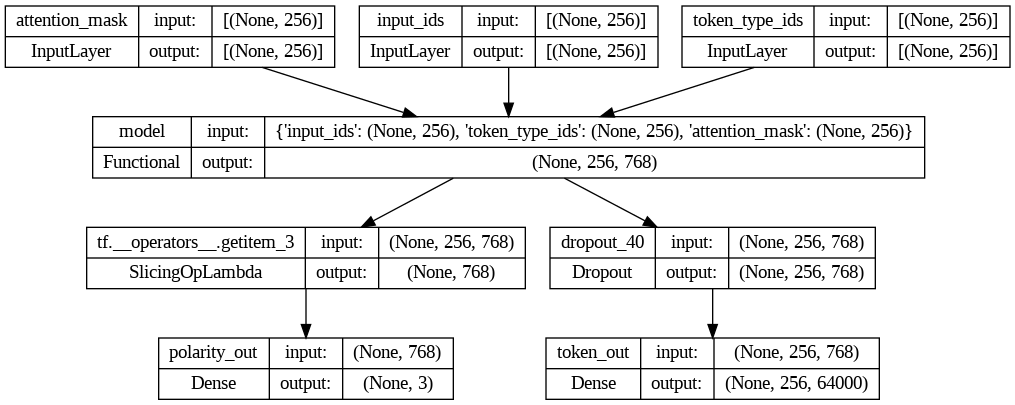

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
dataset_dev

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.float64, name=None), 'token_type_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.float64, name=None)}, {'polarity_out': TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), 'token_out': TensorSpec(shape=(None, 256), dtype=tf.float64, name=None)})>

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 2,
    restore_best_weights = True
    )

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5),loss = losses,loss_weights = loss_weights)

model.fit(
	dataset_train,
	validation_data = dataset_dev,
	epochs=2,
	# callbacks = early_stop,
	verbose=1,
	)

NameError: ignored

In [ ]:
model.save_weights("/content/drive/MyDrive/Đồ án KHDL/ae_checkpoint/phobert--CL-NoASP-test02-2.h5")

In [ ]:
model.load_weights("/content/drive/MyDrive/Đồ án KHDL/ae_checkpoint/phobert-CL-NoASP.h5")

## EVALUATION

In [ ]:
def convert_unicode(text):
  char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
  charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
  char1252 = char1252.split('|')
  charutf8 = charutf8.split('|')

  dic = {}
  for i in range(len(char1252)): dic[char1252[i]] = charutf8[i]
  return re.sub(
      r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
      lambda x: dic[x.group()], text
  )


In [ ]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.2.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [ ]:
sent_asp_data = LoadSentenceAspectData("/content/drive/MyDrive/Đồ án KHDL/test_300_Quy.json")
sentences, aspects,polarities = sent_asp_data.load()

In [ ]:
tag2idx = {"Neutral":1,"Positive":2,"Negative":0}
idx2tag = {v:k for k,v in tag2idx.items()}


In [ ]:
sentences, aspects,polarities = remove_duplicate_aspects(sentences,aspects,polarities)


In [ ]:
text_normalize = TextNormalize()
sentences_normalized = np.asarray(list(map(lambda x:text_normalize.normalize(x),sentences)))
aspects_normalized = np.asarray(list(map(lambda x:text_normalize.normalize(x),aspects)))

In [ ]:
sentences_normalized[:5],aspects_normalized[:5]

(array(['bánh bèo chén ở đây rất ấn tượng.bánh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.quán có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí. mình hay tới đây ăn vào dịp cuối tuần lắm',
        'bánh bèo chén ở đây rất ấn tượng.bánh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.quán có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí. mình hay tới đây ăn vào dịp cuối tuần lắm',
        'bánh bèo chén ở đây rất ấn tượng.bánh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.quán có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí. mình hay tới đây ăn vào dịp cuối tuần lắm',
        'bánh bèo chén ở đây rất ấn tượng.bánh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.quán có nhiều thực đơn món ăn phong phú mà giá cả lại rất h

In [ ]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.2.jar", annotators="wseg", max_heap_size='-Xmx500m')
sentences_segments = list(map(lambda x:" ".join([" ".join(i) for i in rdrsegmenter.tokenize(x)]),sentences_normalized))
aspects_segments = list(map(lambda x: " ".join(rdrsegmenter.tokenize(x)[0]),aspects_normalized)) #aspect cant not be split


In [ ]:
sentences_segments

['bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mình hay tới đây ăn vào dịp cuối tuần lắm',
 'bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mình hay tới đây ăn vào dịp cuối tuần lắm',
 'bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mình hay tới đây ăn vào dịp cuối tuần lắm',
 'bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mì

In [ ]:
X_pair = list(zip(sentences_segments,aspects_segments))
X_pair[:5],polarities[:5]

([('bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mình hay tới đây ăn vào dịp cuối tuần lắm',
   'bánh beo'),
  ('bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mình hay tới đây ăn vào dịp cuối tuần lắm',
   'bánh bèo chén'),
  ('bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mình hay tới đây ăn vào dịp cuối tuần lắm',
   'giá cả'),
  ('bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều t

In [ ]:
# <s> aspect </s> </s> context </s>
def sentence_aspect_pair(X,polarities,tokenizer,batch_size,is_shuffle = False):
  tag2idx = {"Neutral":1,"Positive":2,"Negative":0}
  idx2tag = {v:k for k,v in tag2idx.items()}

  features = {k:[] for k in tokenizer.model_input_names}

  for i in range(len(X)):
    token = tokenizer(X[i][1],X[i][0],padding = 'max_length',max_length = MAX_LEN,truncation="only_second")
    for name in tokenizer.model_input_names:
      if name == 'token_type_ids':
        a = np.asarray(token['input_ids'])
        first,end = np.argwhere(a==2)[0],np.argwhere(a==2)[-1]
        token_type_id = [[0]* (first[0]+1) + [1] * (end[0]-first[0]-1) + [0]*(MAX_LEN - end[0])]
        features[name].append(np.asarray(token_type_id[0]))
        continue
      temp = np.asarray(token[name]).astype('float')
      features[name].append(temp)

  for k,v in features.items():
    features[k] = np.asarray(features[k])

  y_encode = list(map(lambda x:tag2idx[x],polarities))
  y_new = [to_categorical(y_encode[i],num_classes = len(tag2idx)) for i in range(len(y_encode))]

  dataset = Dataset.from_tensor_slices((features, y_new))
  if is_shuffle:
    dataset = dataset.shuffle(buffer_size = len(y_new))
  dataset = dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

  return dataset

In [ ]:
test_data = sentence_aspect_pair(X_pair,polarities,tokenizer,2)


In [ ]:
y_pred_polarities = []
y_pred_tokens = []
for data in test_data:
    y_pred_polarity,y_pred_token = model(data[0])
    y_pred_polarity = np.argmax(y_pred_polarity,axis=-1)
    y_pred_token = np.argmax(y_pred_token,axis=-1)
    y_pred_polarities.extend(y_pred_polarity)
    y_pred_tokens.extend(y_pred_token)
    tf.keras.backend.clear_session()

In [ ]:
y_pred_polarities = np.asarray(y_pred_polarities)
print(y_pred_polarities)

[2 2 1 ... 1 2 2]


In [ ]:
y_temp = np.asarray(list(map(lambda x: tag2idx[x],polarities)))
y_temp

array([2, 2, 2, ..., 1, 1, 2])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_temp, y_pred_polarities,digits = 4))

              precision    recall  f1-score   support

           0     0.6018    0.8293    0.6974       164
           1     0.7993    0.7736    0.7863       932
           2     0.8733    0.8522    0.8626      1319

    accuracy                         0.8203      2415
   macro avg     0.7582    0.8183    0.7821      2415
weighted avg     0.8263    0.8203    0.8219      2415



## RANDOM SENTENCE

In [ ]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.2.jar", annotators="wseg", max_heap_size='-Xmx500m')


In [ ]:
rd_sample_text = "Trà Phúc Long 12k/1 ly hay sao đó mình hông nhớ rõ lắm, cho nhiều sữa đặc quá nên ngọt ngây luôn không có vị trà @@. Trà chanh 10k/1 ly, nói là chanh chứ toàn nghe mùi tắc thôi, ngọt hơi gắt luôn đó chắc cho lố đường."
rd_sample_aspect = "Trà chanh"

normal_text = TextNormalize().normalize(convert_unicode(rd_sample_text))
# normal_text = convert_unicode(rd_sample_text)
normal_text = " ".join([" ".join(i) for i in rdrsegmenter.tokenize(normal_text)])
normal_text = re.sub("< (\w+) >",r"<\1>",normal_text)

normal_aspect = TextNormalize().normalize(convert_unicode(rd_sample_aspect))
normal_aspect = convert_unicode(rd_sample_aspect)
normal_aspect = " ".join(rdrsegmenter.tokenize(normal_aspect)[0])
normal_aspect = re.sub("< (\w+) >",r"<\1>",normal_aspect)

token = tokenizer(normal_aspect,normal_text,padding = 'max_length',max_length = MAX_LEN,truncation=True)

In [ ]:
tokenizer.decode(token['input_ids'])

'<s> Trà chanh </s> </s> trà phúc long 12 k / 1 ly hay sao đó mình hông nhớ rõ lắm, cho nhiều sữa đặc quá nên ngọt ngây luôn không có vị trà. trà chanh 10 k / 1 ly, nói là chanh chứ toàn nghe mùi tắc thôi, ngọt hơi gắt luôn đó chắc cho lố đường. </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

In [ ]:
features = {i : [[token[i]]] for i in tokenizer.model_input_names}

In [ ]:
te = Dataset.from_tensor_slices(features)
te

<_TensorSliceDataset element_spec={'input_ids': TensorSpec(shape=(1, 256), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(1, 256), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(1, 256), dtype=tf.int32, name=None)}>

In [ ]:
y_pred_polarity = org_model.predict(te,batch_size=1)
# y_pred = np.argmax(y_pred,axis=-1)
y_pred_polarity = idx2tag[np.argmax(y_pred_polarity,axis=-1)[0]]
y_pred_polarity

1/1 [==============================] - 2s 2s/step


'Neutral'

In [ ]:
y_pred_polarity,y_pred_token = model.predict(te,batch_size=1)
y_pred_polarity = idx2tag[np.argmax(y_pred_polarity,axis=-1)[0]]
print(y_pred_polarity)
y_pred_token = np.argmax(y_pred_token,axis=-1)
tokenizer.decode(y_pred_token[0])

1/1 [==============================] - 3s 3s/step
Neutral


'</s> trà chanh </s> </s> trà cay long 12 k / 1 ly hay sao đó mình ko nhớ rõ lắm, cho nhiều sữa đặc quá nên ngọt chắc luôn không có vị trà. trà chanh 10 k / 1 ly, nói là chanh chứ toàn nghe mùi tắc thôi, ngọt hơi mặn luôn đó chắc cho ít đường. </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <

# COMPARE ORIGINAL AND NO-ASPECT TEMPLATE

## ORIGINAL

In [ ]:
org_model.load_weights("/content/drive/MyDrive/Đồ án KHDL/ae_checkpoint/phobert-asp-testsize02.h5")

In [ ]:
y_test_pred = np.argmax(org_model.predict(test_data,batch_size = BATCH_SIZE),axis=-1)
y_test_pred = y_test_pred.reshape((1,-1))[0]

1208/1208 [==============================] - 68s 55ms/step


In [ ]:
print(y_test_pred)

[2 2 2 ... 2 2 2]


In [ ]:
y_temp = np.asarray(list(map(lambda x: tag2idx[x],polarities)))
y_temp

array([2, 2, 2, ..., 1, 1, 2])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_temp, y_test_pred,digits = 4))

              precision    recall  f1-score   support

           0     0.7949    0.7561    0.7750       164
           1     0.8756    0.5740    0.6935       932
           2     0.7646    0.9553    0.8493      1319

    accuracy                         0.7946      2415
   macro avg     0.8117    0.7618    0.7726      2415
weighted avg     0.8095    0.7946    0.7841      2415



## NO-ASPECT TEMPLATE